# Trams delays in Cracow

### The analysis concerns in majority usage of machine learning in this casual situation, which is public mean of transport. I won't focus on statistical approach to the issue, neither on visualizing data - this I will try to complete in the near future, in order to receive comprehensive project. The data come from someone's GitHub, where the owner focuses merely on statistics. That is why I have decided to reuse them for ML.

In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


In [2]:
#Easy uploading data

def reader_csv(list):
    """ Allows for uploading data from the list """
    df_list = []
    
    for i in range(len(list)):
        reader = pd.read_csv(list[i])
        df_list.append(reader)
    return df_list

In [3]:
#Obtaining a part from whole dataset, due to time-consuming computations (when not using cloud)

paths_list = ['https://raw.githubusercontent.com/aczepielik/KRKtram/master/reports/report_07-23.csv',
              'https://raw.githubusercontent.com/aczepielik/KRKtram/master/reports/report_07-24.csv',
              'https://raw.githubusercontent.com/aczepielik/KRKtram/master/reports/report_07-25.csv']

In [4]:
#Load data into data frames

df_list = reader_csv(paths_list)
df = pd.concat(df_list, ignore_index= True)
df.shape

(216615, 12)

In [5]:
#Checking if there are any 'Nans'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216615 entries, 0 to 216614
Data columns (total 12 columns):
index          216615 non-null int64
time_stamp     216615 non-null object
stop           216615 non-null int64
stopName       216615 non-null object
number         216615 non-null int64
direction      216615 non-null object
plannedTime    216615 non-null object
vehicleId      190358 non-null float64
tripId         216615 non-null int64
status         216615 non-null object
delay          216615 non-null int64
seq_num        214615 non-null float64
dtypes: float64(2), int64(5), object(5)
memory usage: 19.8+ MB


##### As we may notice, some NaN values occur. To avoid inconveniences before enclosing data, we firstly fill empty places with an unique value to differentiate them from the remaining values.

In [6]:
#Let's check how data looks like in general

df.head(5)

,index,time_stamp,stop,stopName,number,direction,plannedTime,vehicleId,tripId,status,delay,seq_num
0,1,2018-07-23 06:00:45,378,Os.Piastów,21,Kopiec Wandy,2018-07-23 05:59:00,NaN,6351558574044883205,PLANNED,1,1.0
1,1,2018-07-23 06:00:47,612,Borsucza,22,Walcownia,2018-07-23 06:00:00,6.352185e+18,6351558574044899587,STOPPING,0,7.0
2,1,2018-07-23 06:00:48,572,Smolki,11,Czerwone Maki P+R,2018-07-23 06:00:00,6.352185e+18,6351558574044670211,STOPPING,0,10.0
3,1,2018-07-23 06:00:49,319,Jubilat,1,Wzgórza K.,2018-07-23 05:59:00,NaN,6351558574044363010,PLANNED,1,3.0
4,1,2018-07-23 06:00:49,322,Filharmonia,8,Bronowice Małe,2018-07-23 06:01:00,6.352185e+18,6351558574044592386,STOPPING,0,15.0


In [7]:
#Column names

df.columns

Index(['index', 'time_stamp', 'stop', 'stopName', 'number', 'direction',
       'plannedTime', 'vehicleId', 'tripId', 'status', 'delay', 'seq_num'],
      dtype='object')

0     0.414376
1     0.357847
2     0.116982
3     0.057304
4     0.027644
5     0.012312
6     0.005803
7     0.003375
8     0.001685
9     0.001159
10    0.000702
11    0.000300
12    0.000157
13    0.000111
14    0.000166
15    0.000051
16    0.000014
18    0.000005
19    0.000009
Name: delay, dtype: float64
Maximum delay is: 19 min
Direction with maximum delay is: Krowodrza Górka
Maximum delay: 19 min, occured 2 times


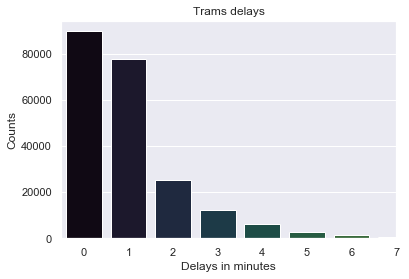

In [8]:
#Helpful charts and maximum values

sns.set()
print(df['delay'].value_counts(normalize=True).sort_index())
print('Maximum delay is: {} min'.format(df['delay'].max()))
print('Direction with maximum delay is: {}'.format(df['direction'].iloc[df['delay'].idxmax()]))
print('Maximum delay: {} min, occured {} times'.format(df['delay'].max(), np.sum(df['delay'] == df['delay'].max())))

_ = sns.countplot(x='delay', data=df, palette='cubehelix')
_ = plt.xlabel('Delays in minutes')
_ = plt.ylabel('Counts')
_ = plt.title('Trams delays')
_ = plt.xlim((-0.5,7))

##### For the apprehensive ones, trams in Krakow tend to arrive on time - approx. 40% of them aren't delayed. Regardless of this, 60% are late (luckily in majority up to 3 min)

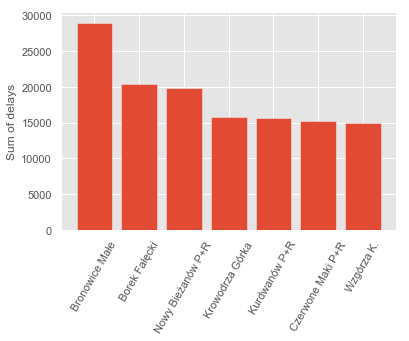

In [9]:
#Finding out, which directions to avoid (in terms of delays)

df1 = df.groupby('direction', 
                 as_index=False).agg({'delay': 'sum'}).sort_values('delay', ascending=False).head(7)

_ = plt.style.use('ggplot')
_ = plt.bar(df1.iloc[:,0], df1.iloc[:,1])
_ = plt.xticks(rotation=60)
_ = plt.ylabel('Sum of delays')

#### It seems like there is one inglorious leader. As I mentioned before whole data analysis isn't main goal of this particular case, but I hope to complete it in the very near future

## Scikit-learn approach.
### Attempting to find out, how much will the tram be delayed (the regression problem)

In [10]:
#Setting up seed to provide repetitive results

seed = 7
np.random.seed(seed)

In [11]:
#Changing type of values to enamble working on numbers
#Adding also some extra new features by combining two columns, in order to improve results (as an assumption)

df['direction_cat'] = df.direction.factorize()[0]
df['number_direction'] = df.apply(lambda x: '{} {}'.format(x['number'], x['direction']), axis=1).factorize()[0]
df['stop_direction'] = df.apply(lambda x: '{} {}'.format(x['stop'], x['direction']), axis=1).factorize()[0]

#Let's multiply delay provided in min to receive seconds for legibility

df['delay_sec'] = df.delay.apply(lambda x: x*60)

In [12]:
#Choosing propper features for the model

feats = ['number', 'stop', 'direction_cat', 'vehicleId', 'seq_num', 'number_direction', 'stop_direction']

X = df[feats].values
y = df['delay_sec'].values

In [13]:
#Defining model with regression solver

model = DecisionTreeRegressor(max_depth=10, random_state=42)

#Defining pipeline

pipeline = Pipeline([('impt', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('scaler', StandardScaler()),
                     ('model', model)])

params_grid = {'model__max_depth': np.arange(1,15)}

#Exhaustive search over specified parameter values for an estimator

cv = GridSearchCV(pipeline, params_grid, cv=3)

scores = cross_val_score(cv, X, y, cv=5, scoring='neg_mean_absolute_error')
np.mean(scores), np.std(scores)

(-49.036011709444054, 2.47377324234954)

#### The received result would be decreased probably for about 1 sec, applying different solution manners

## Scikit-learn approach. 
### Considering whether delay will occur at all (the classification problem)

In [14]:
#Defining function, that changes values respectively to 0 or 1. That changes regression problem to classification one

def change_to_zero(row):
    """Changes to 1 when delay occurs and when it doesn't, to 0"""
    if row != 0:
        return 1
    else:
        return 0

#Creating new column

df['Delay_or_not'] = df.delay.apply(change_to_zero)
df.Delay_or_not.value_counts(normalize=True)

1    0.585624
0    0.414376
Name: Delay_or_not, dtype: float64

In [15]:
df.head(5)

,index,time_stamp,stop,stopName,number,direction,plannedTime,vehicleId,tripId,status,delay,seq_num,direction_cat,number_direction,stop_direction,delay_sec,Delay_or_not
0,1,2018-07-23 06:00:45,378,Os.Piastów,21,Kopiec Wandy,2018-07-23 05:59:00,NaN,6351558574044883205,PLANNED,1,1.0,0,0,0,60,1
1,1,2018-07-23 06:00:47,612,Borsucza,22,Walcownia,2018-07-23 06:00:00,6.352185e+18,6351558574044899587,STOPPING,0,7.0,1,1,1,0,0
2,1,2018-07-23 06:00:48,572,Smolki,11,Czerwone Maki P+R,2018-07-23 06:00:00,6.352185e+18,6351558574044670211,STOPPING,0,10.0,2,2,2,0,0
3,1,2018-07-23 06:00:49,319,Jubilat,1,Wzgórza K.,2018-07-23 05:59:00,NaN,6351558574044363010,PLANNED,1,3.0,3,3,3,60,1
4,1,2018-07-23 06:00:49,322,Filharmonia,8,Bronowice Małe,2018-07-23 06:01:00,6.352185e+18,6351558574044592386,STOPPING,0,15.0,4,4,4,0,0


In [16]:
#Dividing data into numeric and text by defining proper lists comprehensions

LABELS = ['stopName', 'direction', 'status', 'plannedTime', 'time_stamp']
NUMBERS = [n for n in df.columns if n not in LABELS]
NUMBERS_NO_TARGET = [n for n in NUMBERS if n != 'Delay_or_not' ]
TO_TRAIN = [n for n in df.columns if n != 'Delay_or_not']
target = df['Delay_or_not']

In [17]:
df.dtypes

index                 int64
time_stamp           object
stop                  int64
stopName             object
number                int64
direction            object
plannedTime          object
vehicleId           float64
tripId                int64
status               object
delay                 int64
seq_num             float64
direction_cat         int64
number_direction      int64
stop_direction        int64
delay_sec             int64
Delay_or_not          int64
dtype: object

#### To grasp NLP a little, now I define function that merges text columns to empower my model executing function called CountVectorizer()

In [18]:
#Defining function, that merges text columns

def combine_obj_col(data_frame, to_drop = NUMBERS):
    """ Merging text columns. Numeric columns are being dropped """
    
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    data_to_drop = data_frame.drop(to_drop, axis=1)
    data_to_drop.fillna("", inplace=True)
    
    return data_to_drop.apply(lambda x: " ".join(x), axis=1)

#Defining functions that retreive values respectively with text, or numbers

get_object_data = FunctionTransformer(combine_obj_col, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMBERS_NO_TARGET], validate=False)

In [19]:
#Preparing pipeline with FeatureUnion

numeric_pipeline = Pipeline([('select1', get_numeric_data),
                            ('imput', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

text_pipeline = Pipeline([('select2', get_object_data),
                            ('vectorizer', CountVectorizer())])

main_pipeline = Pipeline([('union', FeatureUnion([
                            ('numeric', numeric_pipeline),
                            ('text', text_pipeline)])),
                          ('knn', KNeighborsClassifier())])

In [20]:
#Spliting up data to train and test set

X_train, X_test, y_train, y_test = train_test_split(df[TO_TRAIN], pd.get_dummies(target) , 
                                                    test_size=0.3, random_state=42)

In [21]:
#Results

main_pipeline.fit(X_train, y_train)
y_pred = main_pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred)

print('Score: {}'.format(score))

Score: 0.5438024159421405


#### The final score still can be improved, applying different optimizing solution

## Keras approach

### Still searching for the answer, whether tram will be late 

In [62]:
#Preparing data to predict

data_to_pred = df[NUMBERS].tail(16500).fillna(-1000).values
data_to_pred.shape
df.shape

(216615, 17)

In [63]:
#Splitting up data

predictors = df[NUMBERS].head(150000).fillna(-1000).values
trget_value = to_categorical(df['Delay_or_not'].head(150000))

n_cols = predictors.shape[1]

In [64]:
#Ensuring, the model stops validating, if there is no improvement in two recent epochs

early_stop = EarlyStopping(patience=3)

In [70]:
#Spliting up data to train and test set

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(predictors, trget_value, test_size=0.2, random_state=42)

#Building our model

model = Sequential()
model.add(Dense(100, activation = 'sigmoid', input_shape=(n_cols,)))
model.add(Dense(100, activation = 'sigmoid'))
model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
model_training = model.fit(X_train_k, y_train_k, validation_data=(X_test_k,y_test_k), epochs=15, verbose=2, callbacks=[early_stop])

Train on 120000 samples, validate on 30000 samples
Epoch 1/15
 - 6s - loss: 0.6191 - acc: 0.5672 - val_loss: 0.6144 - val_acc: 0.5800
Epoch 2/15
 - 5s - loss: 0.6158 - acc: 0.5719 - val_loss: 0.6152 - val_acc: 0.5800
Epoch 3/15
 - 5s - loss: 0.6153 - acc: 0.5719 - val_loss: 0.6146 - val_acc: 0.5800
Epoch 4/15
 - 6s - loss: 0.6153 - acc: 0.5739 - val_loss: 0.6143 - val_acc: 0.5800
Epoch 5/15
 - 6s - loss: 0.6153 - acc: 0.5743 - val_loss: 0.6142 - val_acc: 0.5800
Epoch 6/15
 - 6s - loss: 0.6150 - acc: 0.5746 - val_loss: 0.6142 - val_acc: 0.5800
Epoch 7/15
 - 6s - loss: 0.6152 - acc: 0.5739 - val_loss: 0.6151 - val_acc: 0.5800
Epoch 8/15
 - 6s - loss: 0.6152 - acc: 0.5738 - val_loss: 0.6142 - val_acc: 0.5800


In [74]:
#Score

predictions = model.predict_proba(data_to_pred)
score = model.evaluate(X_test_k, y_test_k, verbose=0)
print(score)

[0.6142359520276387, 0.5799666666666666]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


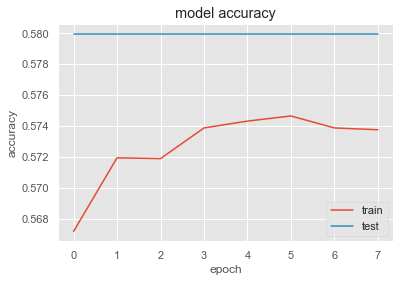

In [71]:
print(model_training.history.keys())

#Summarize history for the accuracy

_ = plt.plot(model_training.history['acc'])
_ = plt.plot(model_training.history['val_acc'])
_ = plt.title('model accuracy')
_ = plt.ylabel('accuracy')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'test'], loc='best')

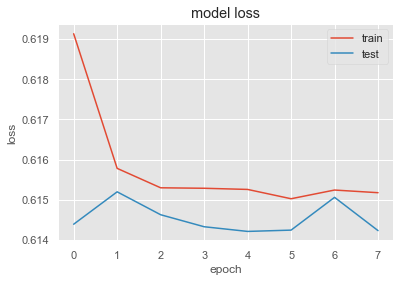

In [72]:
#Summarize history for the loss

_ = plt.plot(model_training.history['loss'])
_ = plt.plot(model_training.history['val_loss'])
_ = plt.title('model loss')
_ = plt.ylabel('loss')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'test'], loc='best')

### Final thoughts

#### Two different approaches to the classification problem, and one to regression models were presented above. Still, there can be applied various solutions using more or less complex optimization manners. Regardless of this fact, I hope the analysis brings closer and briefly clarifies the issue, so that it is no longer vague.